In [2]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import xcdat
import pandas as pd

import functions.data_wrangling as dw
import annular_modes as am

2025-04-14 11:00:27,701 [WARNING]: temporal.py(_set_data_var_attrs:935) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2025-04-14 11:00:27,701 [WARNING]: temporal.py(_set_data_var_attrs:935) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2025-04-14 11:00:27,712 [WARNING]: temporal.py(_set_data_var_attrs:935) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, se

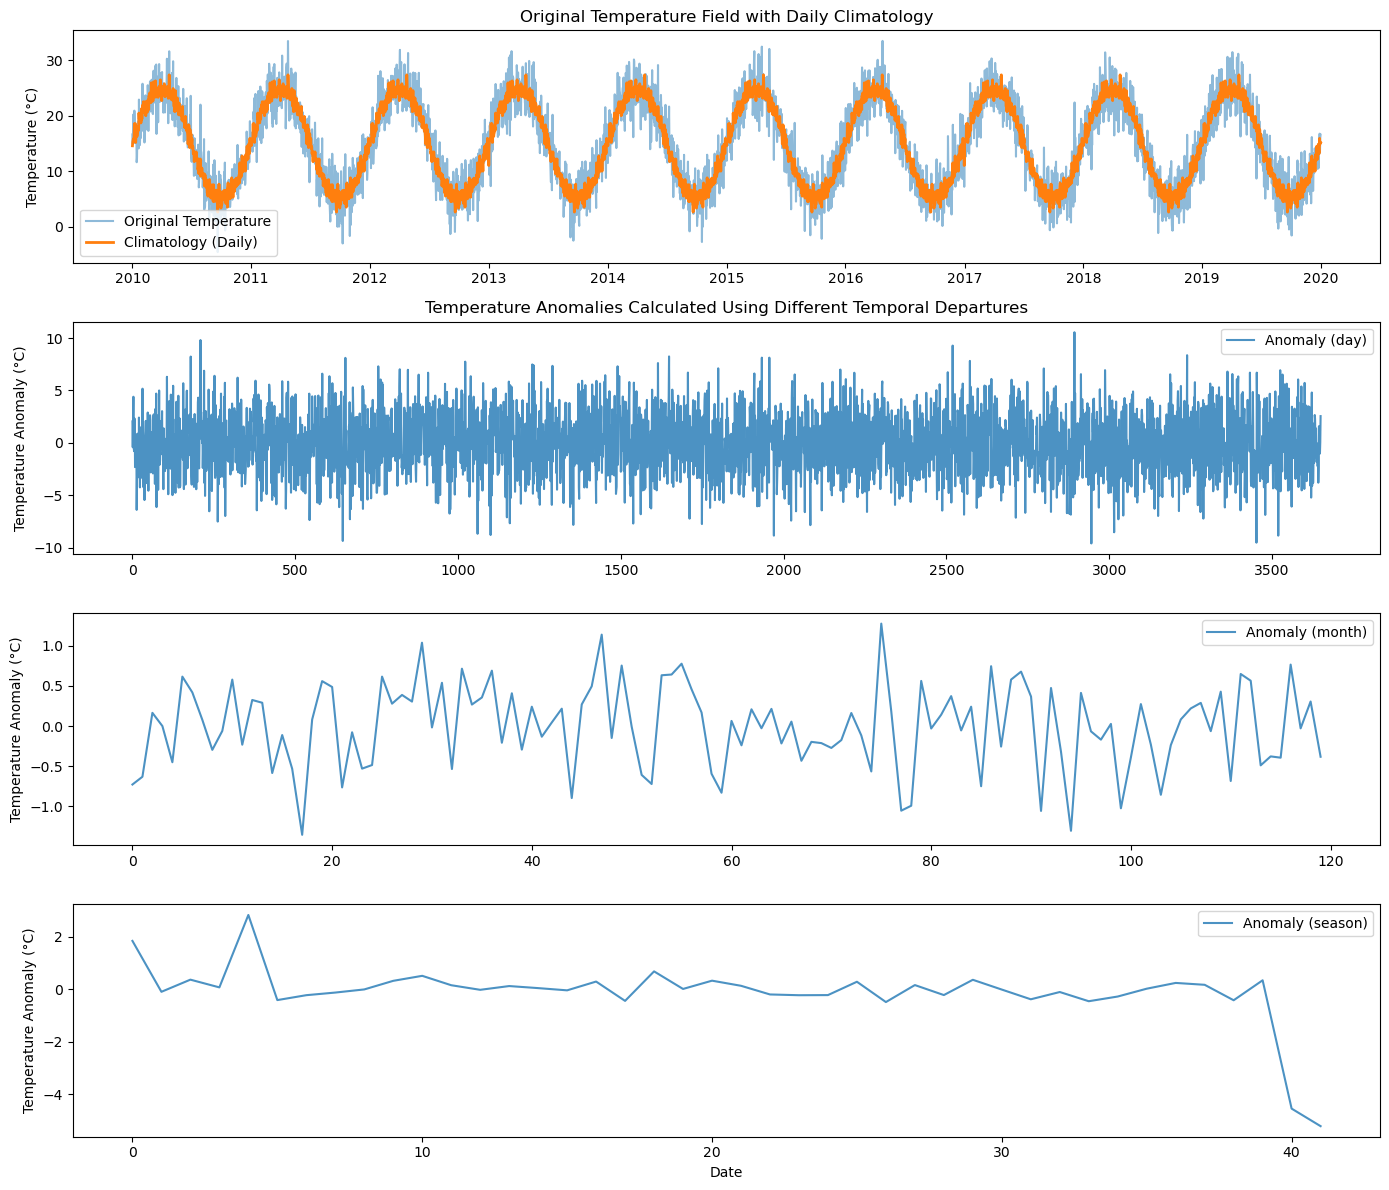

In [3]:


# -------------------------------
# 1. Create a Synthetic Dataset
# -------------------------------

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a daily date range over 10 years
dates = pd.date_range(start='2010-01-01', end='2019-12-31', freq='D')
n = len(dates)

# Define parameters for the sine wave (annual cycle)
amplitude = 10       # degrees of variation
mean_temp = 15       # base temperature in °C

# Create the seasonal (climate) component using a sine wave.
# We use 365.25 days to approximately account for leap years.
seasonal = amplitude * np.sin(2 * np.pi * (dates.dayofyear / 365.25)) + mean_temp

# Add random noise to simulate weather fluctuations.
noise_std = 3.0  # standard deviation of the noise
noise = np.random.normal(0, noise_std, size=n)

# The synthetic temperature is the sum of the seasonal cycle and noise.
temperature = seasonal + noise

# Create an xarray Dataset with dimension 'time' and variable 'Temp'
ds = xr.Dataset({'Temp': (['time'], temperature)},
                coords={'time': dates})

# -----------------------------------------
# 2. Compute Daily Climatology for the Original Temperature Field
# -----------------------------------------
# Convert the DataArray to a pandas Series to use the transform function.
temp_series = ds['Temp'].to_series()

# Compute the daily climatology (mean for each day-of-year)
clim_series = temp_series.groupby(temp_series.index.dayofyear).transform('mean')

# Convert the climatology back to an xarray DataArray with the same time coordinate.
temp_clim = xr.DataArray(clim_series.values, dims=['time'], coords={'time': ds['time']})

# -----------------------------------------------------------
# 3. Compute Anomalies Using xcdat's ds.temporal.departures
# -----------------------------------------------------------
# Define the list of frequency specifications for which to compute anomalies.
freqs = ['day', 'month', 'season']
anoms = {}
for f in freqs:
    ds = ds.bounds.add_missing_bounds(axes='T')
    anoms[f] = ds.temporal.departures(data_var='Temp', freq=f, weighted=True)['Temp']
    
# -----------------------------------------
# 4. Plot the Original Field with Climatology and Computed Anomalies
# -----------------------------------------
plt.figure(figsize=(14, 12))

# Top subplot: Original Temperature Field with Daily Climatology.
plt.subplot(4, 1, 1)
plt.plot(ds.time, ds['Temp'], label='Original Temperature', alpha=0.5)
plt.plot(ds.time, temp_clim, label='Climatology (Daily)', linewidth=2)
plt.title('Original Temperature Field with Daily Climatology')
plt.ylabel('Temperature (°C)')
plt.legend()

# Subsequent subplots: Anomalies for each frequency method.
for i, f in enumerate(freqs, start=2):
    plt.subplot(4, 1, i)
    plt.plot(anoms[f], label=f'Anomaly ({f})', alpha=0.8)
    plt.ylabel('Temperature Anomaly (°C)')
    plt.legend()
    if i == 2:
        plt.title('Temperature Anomalies Calculated Using Different Temporal Departures')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


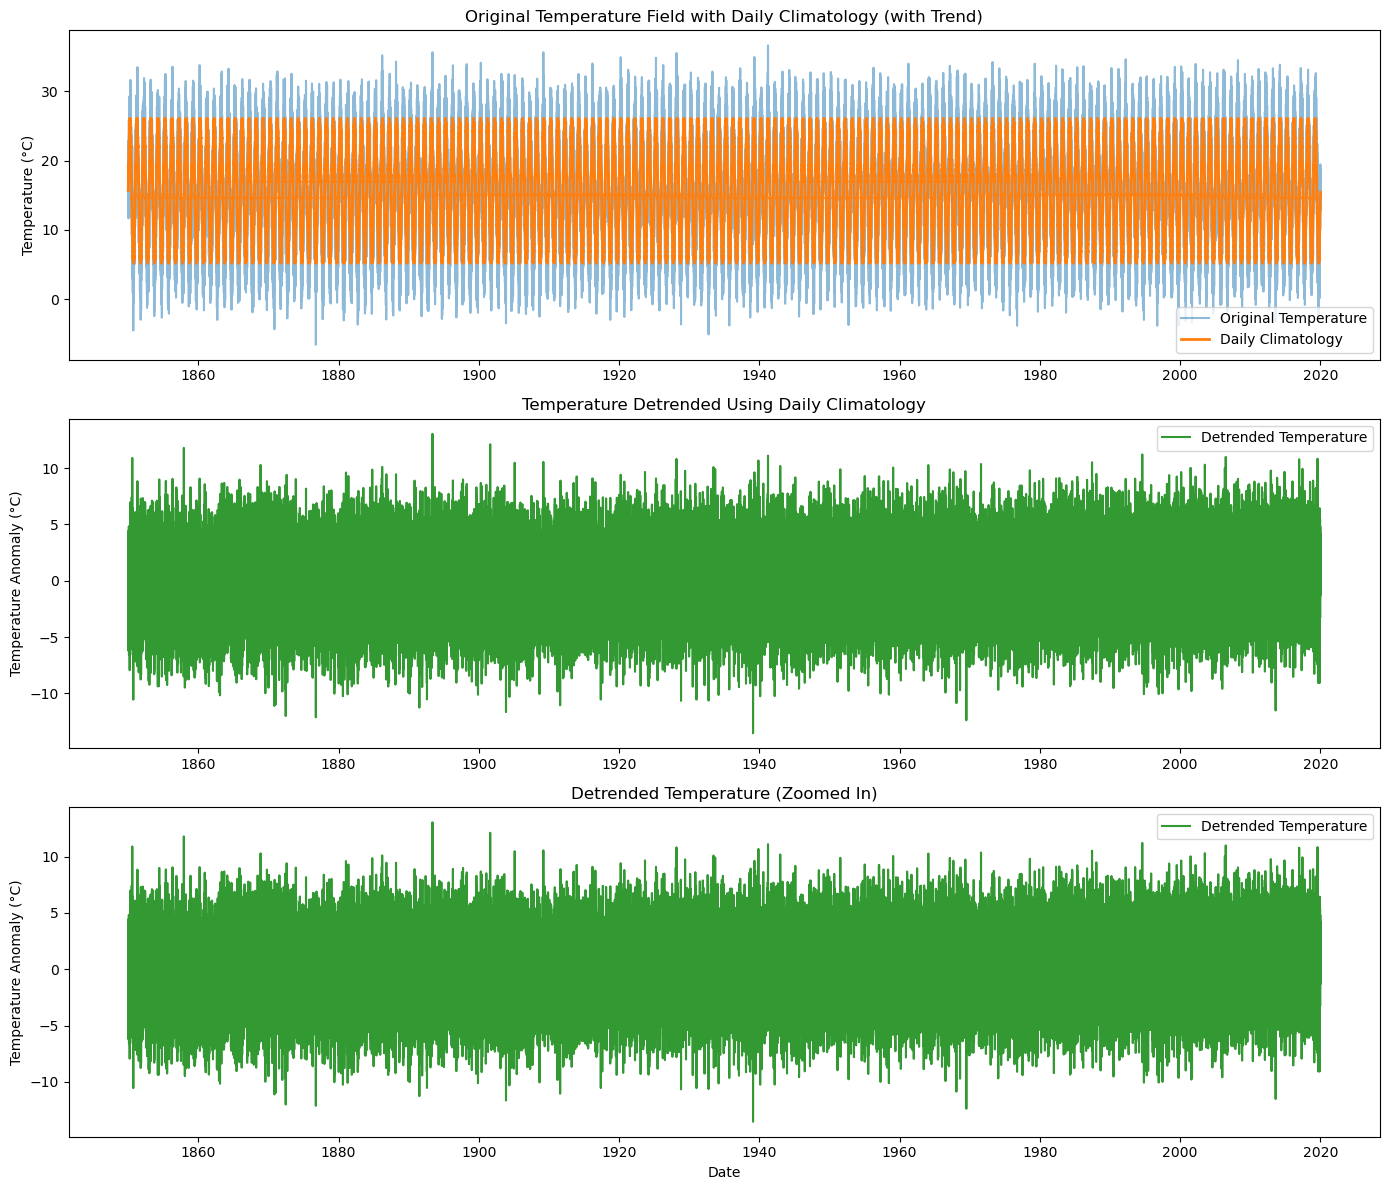

In [8]:


# -------------------------------
# 1. Create a Synthetic Dataset with an Increasing Trend
# -------------------------------

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a daily date range over 10 years
dates = pd.date_range(start='1850-01-01', end='2019-12-31', freq='D')
n = len(dates)

# Define parameters for the sine wave (annual cycle)
amplitude = 10       # degrees of variation
mean_temp = 15       # base temperature in °C

# Create the seasonal (climate) component using a sine wave.
# Using 365.25 days approximately accounts for leap years.
seasonal = amplitude * np.sin(2 * np.pi * (dates.dayofyear / 365.25)) + mean_temp

# Add a linear trend to simulate warming.
# For example, a 1°C increase over the 10-year period.
trend = np.linspace(0, 1, n)

# Add random noise to simulate weather variability.
noise_std = 3.0  # standard deviation of the noise
noise = np.random.normal(0, noise_std, size=n)

# The synthetic temperature is the sum of the seasonal cycle, trend, and noise.
temperature = seasonal + trend + noise

# Create an xarray Dataset with dimension 'time' and variable 'Temp'
ds = xr.Dataset({'Temp': (['time'], temperature)},
                coords={'time': dates})

# -------------------------------
# 2. Compute Daily Climatology for Detrending
# -------------------------------
# To remove the seasonal cycle (and in effect remove an average trend),
# we compute the daily climatology (i.e., mean for each day-of-year).
# We first convert the DataArray to a pandas Series to leverage groupby and transform.
temp_series = ds['Temp'].to_series()
# Compute the mean for each day-of-year across the entire period.
climatology_series = temp_series.groupby(temp_series.index.dayofyear).transform('mean')
# Convert the result back to an xarray DataArray with the same time coordinate.
daily_clim = xr.DataArray(climatology_series.values, dims=['time'], coords={'time': ds['time']})

# -------------------------------
# 3. Detrend the Data by Removing the Daily Climatology
# -------------------------------
# By subtracting the computed daily climatology from the original data,
# we obtain the detrended anomalies.
detrended = ds['Temp'] - daily_clim

# -------------------------------
# 4. Plot the Original Field and the Detrended Data
# -------------------------------
plt.figure(figsize=(14, 12))

# Top subplot: Original Temperature Field with Daily Climatology
plt.subplot(3, 1, 1)
plt.plot(ds.time, ds['Temp'], label='Original Temperature', alpha=0.5)
plt.plot(ds.time, daily_clim, label='Daily Climatology', linewidth=2)
plt.title('Original Temperature Field with Daily Climatology (with Trend)')
plt.ylabel('Temperature (°C)')
plt.legend()

# Middle subplot: Detrended Data (Temperature Anomalies)
plt.subplot(3, 1, 2)
plt.plot(ds.time, detrended, label='Detrended Temperature', color='green', alpha=0.8)
plt.title('Temperature Detrended Using Daily Climatology')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Bottom subplot: (Optional) Zoomed view of the detrended data
plt.subplot(3, 1, 3)
plt.plot(ds.time, detrended, label='Detrended Temperature', color='green', alpha=0.8)
plt.title('Detrended Temperature (Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

plt.tight_layout()
plt.show()


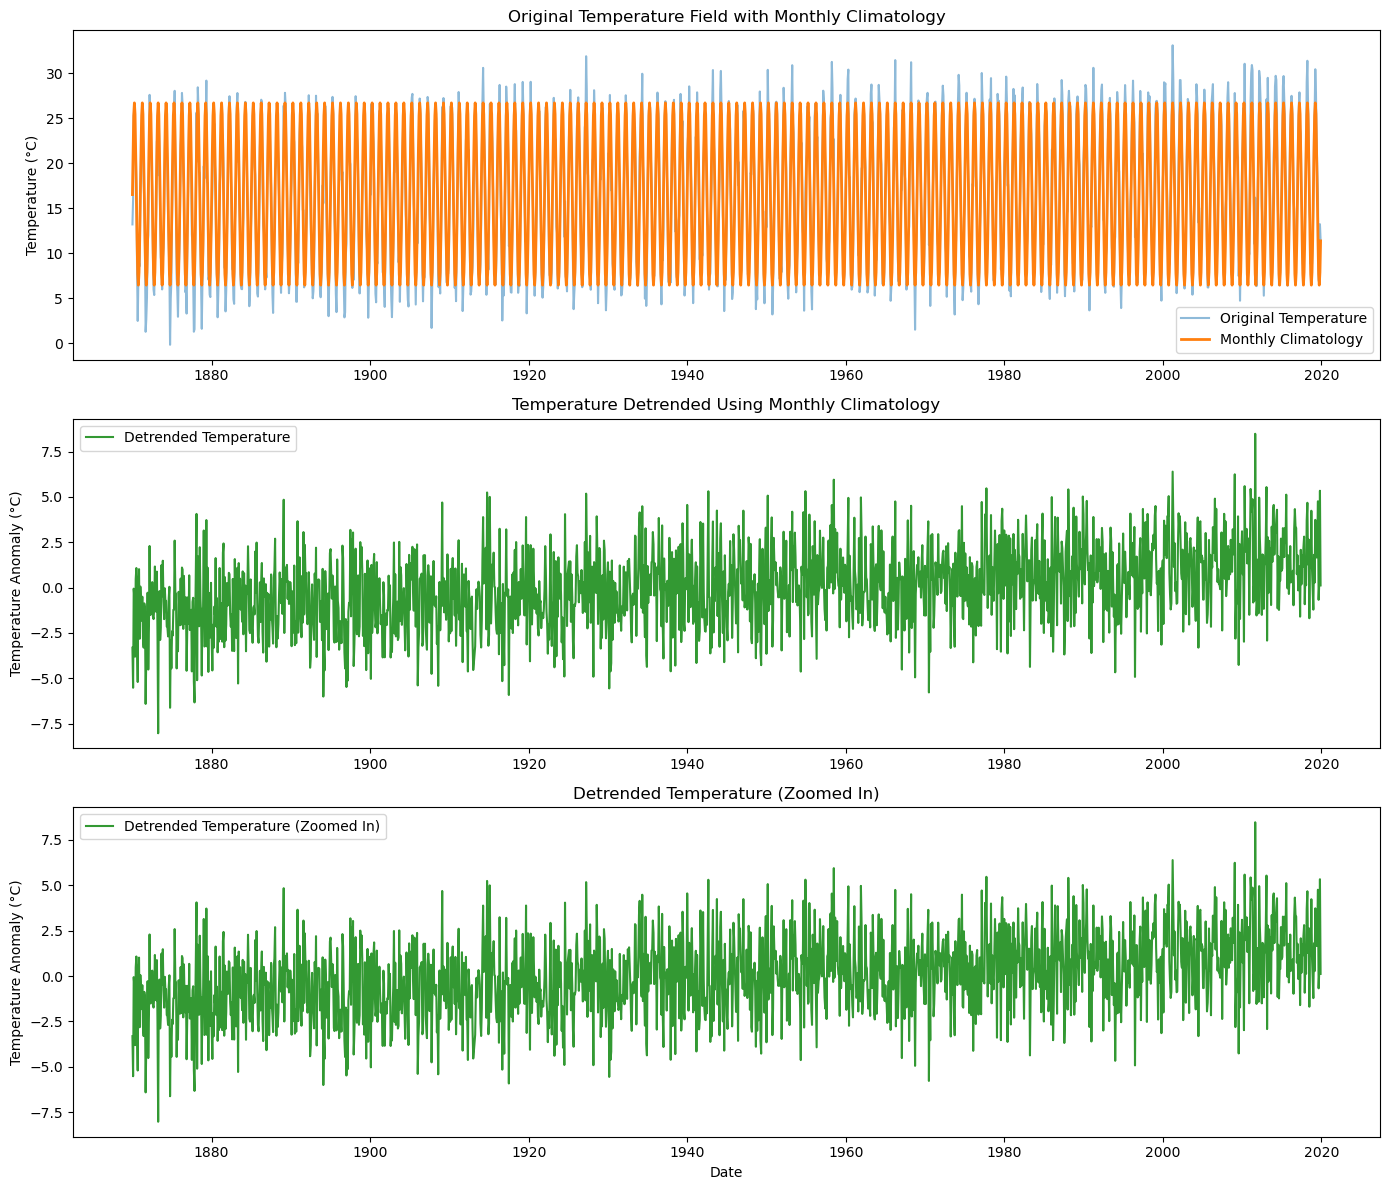

In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# -------------------------------
# 1. Create Synthetic Monthly Data with an Increasing Trend
# -------------------------------

# Generate a monthly date range for 150 years (using month-start frequency)
dates = pd.date_range(start='1870-01-01', periods=150*12, freq='MS')
n = len(dates)

# Define parameters for the seasonal cycle and base temperature
amplitude = 10       # degrees of variation for the seasonal cycle
mean_temp = 15       # base temperature in °C

# Create the seasonal (climate) component using a sine wave.
# The sine wave now has a period of 12 months; we adjust the phase to start at January.
seasonal = amplitude * np.sin(2 * np.pi * (dates.month - 1) / 12) + mean_temp

# Create a linear trend to simulate warming due to climate change.
# Here we assume a 3°C increase over the 150-year period.
trend = np.linspace(0, 3, n)

# Add random noise to simulate weather fluctuations.
noise_std = 2.0  # standard deviation of the noise
noise = np.random.normal(0, noise_std, size=n)

# The synthetic temperature is the sum of the seasonal cycle, trend, and noise.
temperature = seasonal + trend + noise

# Create an xarray Dataset with dimension 'time' and variable 'Temp'
ds = xr.Dataset({'Temp': (['time'], temperature)},
                coords={'time': dates})

# -------------------------------
# 2. Compute Monthly Climatology for Detrending
# -------------------------------
# Convert the temperature DataArray to a pandas Series.
temp_series = ds['Temp'].to_series()

# Compute the monthly climatology by grouping by the calendar month.
# The transform('mean') method returns the mean for each month for every data point.
climatology_series = temp_series.groupby(temp_series.index.month).transform('mean')

# Convert the climatology back to an xarray DataArray using the original time coordinate.
monthly_clim = xr.DataArray(climatology_series.values, dims=['time'], coords={'time': ds['time']})

# -------------------------------
# 3. Detrend the Data by Removing the Monthly Climatology
# -------------------------------
# Subtract the monthly climatology from the original temperature field.
detrended = ds['Temp'] - monthly_clim

# -------------------------------
# 4. Plot the Original Field (with Climatology) and Detrended Data
# -------------------------------
plt.figure(figsize=(14, 12))

# Top subplot: Original Temperature Field with Monthly Climatology
plt.subplot(3, 1, 1)
plt.plot(ds.time, ds['Temp'], label='Original Temperature', alpha=0.5)
plt.plot(ds.time, monthly_clim, label='Monthly Climatology', linewidth=2)
plt.title('Original Temperature Field with Monthly Climatology')
plt.ylabel('Temperature (°C)')
plt.legend()

# Middle subplot: Detrended Data (Temperature Anomalies)
plt.subplot(3, 1, 2)
plt.plot(ds.time, detrended, label='Detrended Temperature', color='green', alpha=0.8)
plt.title('Temperature Detrended Using Monthly Climatology')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Bottom subplot: Zoomed In View of the Detrended Data
plt.subplot(3, 1, 3)
plt.plot(ds.time, detrended, label='Detrended Temperature (Zoomed In)', color='green', alpha=0.8)
plt.title('Detrended Temperature (Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.bounds.add_missing_bounds(axes='T')
ds

<xarray.Dataset> Size: 134GB
Dimensions:    (time: 21550, level: 37, lat: 73, lon: 144, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 172kB 1958-01-01T09:00:00 ... 2016-12-31...
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 584B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Dimensions without coordinates: bnds
Data variables:
    u          (time, level, lat, lon) float32 34GB dask.array<chunksize=(30, 37, 73, 144), meta=np.ndarray>
    v          (time, level, lat, lon) float32 34GB dask.array<chunksize=(30, 37, 73, 144), meta=np.ndarray>
    t          (time, level, lat, lon) float32 34GB dask.array<chunksize=(30, 37, 73, 144), meta=np.ndarray>
    omega      (time, level, lat, lon) float32 34GB dask.array<chunksize=(30, 37, 73, 144), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] 345kB 1958-01-01 ... 2017-01-01

In [11]:
ds = ds.sel(time=slice('1978-03', '2011-02'))
ds

<xarray.Dataset> Size: 75GB
Dimensions:    (time: 12053, level: 37, lat: 73, lon: 144, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 96kB 1978-03-01T09:00:00 ... 2011-02-28T...
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 584B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Dimensions without coordinates: bnds
Data variables:
    u          (time, level, lat, lon) float32 19GB dask.array<chunksize=(16, 37, 73, 144), meta=np.ndarray>
    v          (time, level, lat, lon) float32 19GB dask.array<chunksize=(16, 37, 73, 144), meta=np.ndarray>
    t          (time, level, lat, lon) float32 19GB dask.array<chunksize=(16, 37, 73, 144), meta=np.ndarray>
    omega      (time, level, lat, lon) float32 19GB dask.array<chunksize=(16, 37, 73, 144), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] 193kB 1978-03-01 ... 2011-03-01

In [6]:
save_path = '/home/links/ct715/eddy_feedback/chapter1/annular_modes/data/anoms'
freq = ['day', 'month', 'season']

ds = {}
for f in freq:
    data_path = os.path.join(save_path, f'jra55_daily_u_anoms_{f}.nc')
    if os.path.exists(data_path):
        ds[f] = xr.open_dataset(data_path)
    else:
        anoms = ds.temporal.departures(data_var='u', freq=f, weighted=True)['u'].mean('lon')
        anoms.to_netcdf(data_path)
        anoms.close()
        ds[f] = xr.open_dataset(data_path)


In [7]:
anoms = {}
for f in freq:
    anoms[f] = ds.temporal.departures(data_var='T', freq=f, weighted=True)['T']


AttributeError: 'dict' object has no attribute 'temporal'